In [1]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 2) Load dataset (Mall Customers Kaggle CSV)
# Expected columns commonly include: 'CustomerID','Gender','Age','Annual Income (k$)','Spending Score (1-100)'  # update to actual filename
df = pd.read_csv('S:\SUNNY PC\Elevate Labs\Datasets\Mall_Customers.csv')

print(df.shape)
print(df.head())
print(df.dtypes)

(200, 5)
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


In [4]:
# 3) Feature selection and preprocessing
# Keep numeric behavior variables; drop IDs, handle optional columns
cols_numeric = []
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]) and c.lower() not in ["customerid", "id"]:
        cols_numeric.append(c)

X = df[cols_numeric].copy()

# Optional: encode Gender if present and desired for clustering
if "Gender" in df.columns and not pd.api.types.is_numeric_dtype(df["Gender"]):
    X = pd.concat([X, pd.get_dummies(df["Gender"], drop_first=True)], axis=1)

print("Selected features:", list(X.columns))

# Scale features
scaler = StandardScaler()
Xs = scaler.fit_transform(X)


Selected features: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Male']


In [5]:
# 4) Optional PCA for visualization (2D)
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(Xs)
print("PCA explained variance ratio:", pca.explained_variance_ratio_, "Total:", pca.explained_variance_ratio_.sum())


PCA explained variance ratio: [0.33690046 0.26230645] Total: 0.5992069019819847


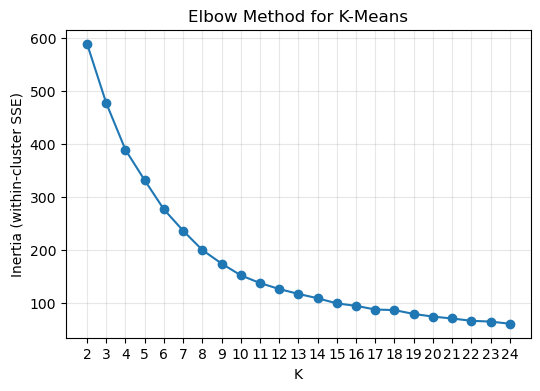

In [8]:
# 5) Elbow method: inertia vs K
Ks = list(range(2, 25))
inertias = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(Xs)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker="o")
plt.xticks(Ks)
plt.xlabel("K")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method for K-Means")
plt.grid(True, alpha=0.3)
plt.show()


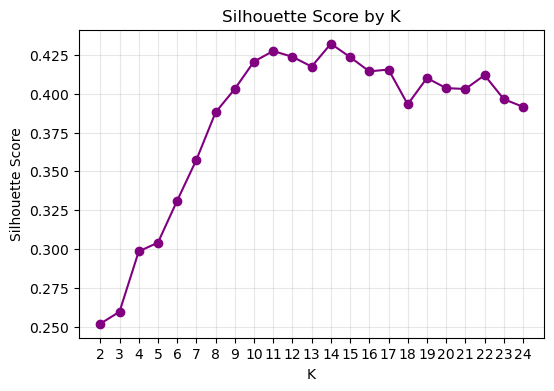

Selected K (by silhouette): 14, score=0.432


In [9]:
# 6) Silhouette scores vs K
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels, metric="euclidean")
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(Ks, sil_scores, marker="o", color="purple")
plt.xticks(Ks)
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score by K")
plt.grid(True, alpha=0.3)
plt.show()

best_k = Ks[int(np.argmax(sil_scores))]
print(f"Selected K (by silhouette): {best_k}, score={max(sil_scores):.3f}")


In [10]:
# 7) Fit final K-Means with best_k
kmeans = KMeans(n_clusters=best_k, n_init=25, random_state=42)
labels = kmeans.fit_predict(Xs)
centers = kmeans.cluster_centers_
overall_sil = silhouette_score(Xs, labels)
print(f"Final model: K={best_k}, inertia={kmeans.inertia_:.1f}, silhouette={overall_sil:.3f}")

# Cluster sizes
unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))


Final model: K=14, inertia=107.9, silhouette=0.431
Cluster sizes: {np.int32(0): np.int64(13), np.int32(1): np.int64(25), np.int32(2): np.int64(15), np.int32(3): np.int64(12), np.int32(4): np.int64(4), np.int32(5): np.int64(25), np.int32(6): np.int64(21), np.int32(7): np.int64(18), np.int32(8): np.int64(6), np.int32(9): np.int64(14), np.int32(10): np.int64(12), np.int32(11): np.int64(13), np.int32(12): np.int64(9), np.int32(13): np.int64(13)}


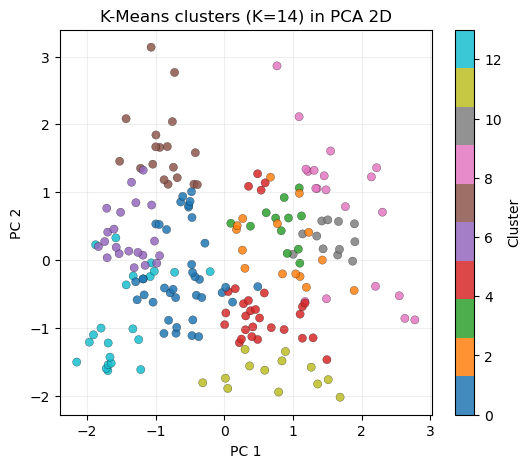

In [11]:
# 8) Visualize clusters in PCA-2D
plt.figure(figsize=(6,5))
scatter = plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="tab10", s=35, alpha=0.85, edgecolor="k", linewidths=0.2)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title(f"K-Means clusters (K={best_k}) in PCA 2D")
plt.colorbar(scatter, label="Cluster")
plt.grid(True, alpha=0.2)
plt.show()


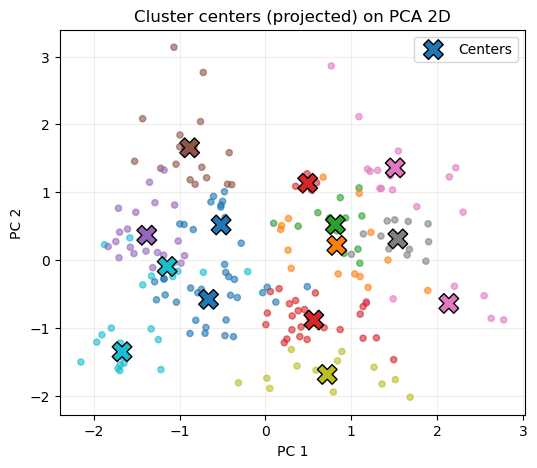

In [12]:
# 9) Project cluster centers into PCA space for visualization (approximate)
centers_2d = pca.transform(centers)

plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=labels, cmap="tab10", s=20, alpha=0.6)
plt.scatter(centers_2d[:,0], centers_2d[:,1], c=np.arange(best_k), cmap="tab10",
            s=200, edgecolor="black", marker="X", label="Centers")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Cluster centers (projected) on PCA 2D")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()
